## **AIRLINE SENTIMENT ANALYSIS USING LSTM**

In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
import tensorflow as tf 
import keras as keras
from gensim.models import Word2Vec
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation , Dropout , Dense
from keras.layers import LSTM,Embedding
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

In [2]:
# import the dataset
tweets = pd.read_csv("../../Airline-Sentiment_data.csv", encoding='ISO-8859-1')
tweets.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,airline_sentiment,airline_sentiment:confidence,negativereason,negativereason:confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_id,tweet_location,user_timezone
0,681448150,False,finalized,3,2/25/15 5:24,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2/24/15 11:35,5.703060e+17,NaN,Eastern Time (US & Canada)
1,681448153,False,finalized,3,2/25/15 1:53,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2/24/15 11:15,5.703010e+17,NaN,Pacific Time (US & Canada)
2,681448156,False,finalized,3,2/25/15 10:01,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2/24/15 11:15,5.703010e+17,Lets Play,Central Time (US & Canada)
3,681448158,False,finalized,3,2/25/15 3:05,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2/24/15 11:15,5.703010e+17,NaN,Pacific Time (US & Canada)
4,681448159,False,finalized,3,2/25/15 5:50,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2/24/15 11:14,5.703010e+17,NaN,Pacific Time (US & Canada)


In [3]:
tweets.drop(['_golden','_unit_state','_trusted_judgments','negativereason','_last_judgment_at','airline_sentiment:confidence','negativereason:confidence','airline_sentiment_gold','negativereason_gold','retweet_count','tweet_coord','tweet_created','tweet_location','user_timezone'] , axis =1 , inplace = True)
tweets.rename(columns={'airline_sentiment':'Target'} , inplace = True)
tweets.head()

,_unit_id,Target,airline,name,text,tweet_id
0,681448150,neutral,Virgin America,cairdin,@VirginAmerica What @dhepburn said.,5.703060e+17
1,681448153,positive,Virgin America,jnardino,@VirginAmerica plus you've added commercials t...,5.703010e+17
2,681448156,neutral,Virgin America,yvonnalynn,@VirginAmerica I didn't today... Must mean I n...,5.703010e+17
3,681448158,negative,Virgin America,jnardino,@VirginAmerica it's really aggressive to blast...,5.703010e+17
4,681448159,negative,Virgin America,jnardino,@VirginAmerica and it's a really big bad thing...,5.703010e+17


In [4]:
tweets.shape

(14640, 6)

In [5]:
tweets.isnull().sum()

_unit_id    0
Target      0
airline     0
name        0
text        0
tweet_id    0
dtype: int64

In [6]:
tweets.Target.value_counts()

Target
negative    9178
neutral     3099
positive    2363
Name: count, dtype: int64

In [7]:
tweets.replace({'Target':{'neutral':1 , 'positive':1 , 'negative': 0}} , inplace=True)
tweets.Target.value_counts()

C:\Users\Avantika\AppData\Local\Temp\ipykernel_30092\44477864.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tweets.replace({'Target':{'neutral':1 , 'positive':1 , 'negative': 0}} , inplace=True)


Target
0    9178
1    5462
Name: count, dtype: int64

<Axes: xlabel='Target', ylabel='count'>

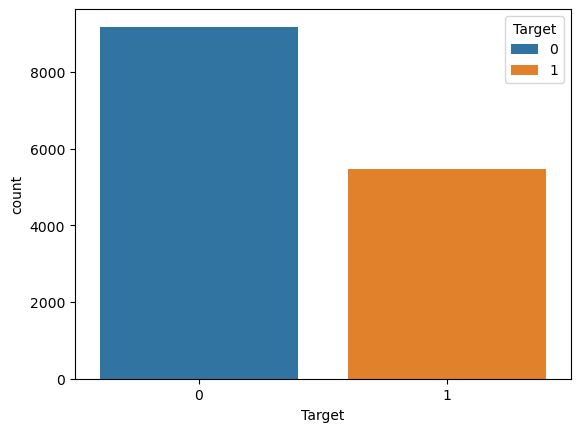

In [8]:
import seaborn as sns
sns.countplot(x='Target',data=tweets ,hue='Target')

#### DATA PREPROCESSING

In [9]:
tweets['text'][0]

'@VirginAmerica What @dhepburn said.'

In [10]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Avantika\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [11]:
tag_re = re.compile('<[^>]+>')

def remove_tags(text):
    return tag_re.sub('',text)

In [13]:
def preprocess_text(sen):
    sentence = sen.lower()
    sentence = remove_tags(sentence)
    sentence = re.sub('[^a-zA-Z]' , ' ' , sentence)
    sentence = re.sub(r"\s+[a-zA-Z]\s+" , ' ' , sentence)
    sentence = re.sub(r'\s+', ' ' , sentence)
    sentence = sentence.split()
    sentence = [word for word in sentence if word not in stopwords.words('english')]
    sentence = ' '.join(sentence)

    return sentence
   

In [14]:
tweets['Cleaned_text'] = tweets['text'].apply(preprocess_text)

In [15]:
tweets.head()

,_unit_id,Target,airline,name,text,tweet_id,Cleaned_text
0,681448150,1,Virgin America,cairdin,@VirginAmerica What @dhepburn said.,5.703060e+17,virginamerica dhepburn said
1,681448153,1,Virgin America,jnardino,@VirginAmerica plus you've added commercials t...,5.703010e+17,virginamerica plus added commercials experienc...
2,681448156,1,Virgin America,yvonnalynn,@VirginAmerica I didn't today... Must mean I n...,5.703010e+17,virginamerica today must mean need take anothe...
3,681448158,0,Virgin America,jnardino,@VirginAmerica it's really aggressive to blast...,5.703010e+17,virginamerica really aggressive blast obnoxiou...
4,681448159,0,Virgin America,jnardino,@VirginAmerica and it's a really big bad thing...,5.703010e+17,virginamerica really big bad thing


In [50]:
x = tweets['Cleaned_text'].values
y = tweets['Target'].values
x

array(['virginamerica dhepburn said',
       'virginamerica plus added commercials experience tacky',
       'virginamerica today must mean need take another trip', ...,
       'americanair please bring american airlines blackberry',
       'americanair money change flight answer phones suggestions make commitment',
       'americanair ppl need know many seats next flight plz put us standby people next flight'],
      dtype=object)

In [51]:
x_train,x_test,y_train,y_test = train_test_split(x,y , test_size = 0.3 , stratify = y , random_state = 42)

In [52]:
x_train

array(['southwestair suggestions tell customers approximate wait times hold min allow cancelled flight online',
       'americanair upset hometown airline stuck den flt cancelled flightled others got new flt info',
       'united exit row window shades approx windows rj lt frequent flyer http co aoeaeszdlx',
       ...,
       'usairways thanks hour flight pit phx zero entertainment guess quarter million miles delta',
       'americanair issuing weather advisory rdu entire state nc shut overnight winter storm',
       'jetblue enough stop flying jetblue'], dtype=object)

In [69]:
max_vocab_size = 10000
tokenizer = Tokenizer(num_words = max_vocab_size)
tokenizer.fit_on_texts(x_train.tolist()) 

sequences = tokenizer.texts_to_sequences(x_train.tolist())
sequences1 = tokenizer.texts_to_sequences(x_test.tolist())

max_sequence_length = 10
x_train_pad = pad_sequences(sequences , maxlen = max_sequence_length)
x_test_pad = pad_sequences(sequences1 , maxlen = max_sequence_length)


word_index = tokenizer.word_index

embedding_dim = 100
vocab_size = len(word_index) + 1

embedding_matrix = np.zeros((vocab_size, embedding_dim))
embedding_matrix.flags.writeable = True


In [55]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Avantika\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.


True

In [58]:
from nltk.tokenize import word_tokenize
sentences = tweets['Cleaned_text'].tolist()

tokenized_sen = [word_tokenize(sen) for sen in sentences]
w2v_model = Word2Vec(tokenized_sen, vector_size=100, window=5, min_count=1, workers=4)

In [59]:
w2v_model.save('word2vec.model')

In [70]:
for word,i in word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]
    else:
        embedding_matrix=np.random.normal(size=(vocab_size,embedding_dim))


In [81]:
model = Sequential()

model.add(Embedding(input_dim=vocab_size,
                    output_dim=embedding_dim,
                    weights=[embedding_matrix],
                    input_length=max_sequence_length,
                    trainable=False))
model.add(LSTM(128))
model.add(Dropout(0.5))                            # Dropout layer added later to increase accuracy
model.add(Dense(1,activation='sigmoid' ,kernel_regularizer=l2(0.01)))                   #l2 regularizer added later to reduce overfitting

model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 10, 100)           1103000   
                                                                 
 lstm_1 (LSTM)               (None, 128)               117248    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,220,377
Trainable params: 117,377
Non-trainable params: 1,103,000
_________________________________________________________________


In [97]:
early_stopping = EarlyStopping(monitor='loss',patience=5,restore_best_weights=True)
model.fit(x_train_pad,y_train,epochs=5,batch_size=32,callbacks=[early_stopping] )

Epoch 1/5
321/321 [==============================] - 4s 13ms/step - loss: 0.0559 - accuracy: 0.9890
Epoch 2/5
321/321 [==============================] - 4s 14ms/step - loss: 0.0545 - accuracy: 0.9906
Epoch 3/5
321/321 [==============================] - 4s 13ms/step - loss: 0.0541 - accuracy: 0.9897
Epoch 4/5
321/321 [==============================] - 4s 14ms/step - loss: 0.0525 - accuracy: 0.9902
Epoch 5/5
321/321 [==============================] - 4s 14ms/step - loss: 0.0731 - accuracy: 0.9821


In [98]:
predictions_prob = model.predict(x_test_pad)

138/138 [==============================] - 1s 5ms/step


In [99]:
predictions = (predictions_prob>=0.5).astype(int)
predictions

array([[1],
       [0],
       [0],
       ...,
       [1],
       [0],
       [0]])

In [100]:
loss,accuracy = model.evaluate(x_test_pad,y_test)

138/138 [==============================] - 1s 6ms/step - loss: 0.8428 - accuracy: 0.7885


In [102]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test,predictions)
print(f"Accuracy: {accuracy}")

Accuracy: 0.7884790528233151


In [104]:
model.save('lstm_model.h5')